<h1> Veštačke neuronske mreže </h1>

Skup podata sadrži rezultate simulacija stabilnosti za referentnu zvezdastu mrežu sa 4 čvora. Sadrži 60.000 zapažanja. Takođe sadrži 12 karakteristika i dve zavisne promenljive.
Cilj je predvideti stabilnost pametne mreže.

Skup podataka nalazi se na linku: <a> https://www.kaggle.com/pcbreviglieri/smart-grid-stability </a>. 

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers
import keras.backend as K
from sklearn.decomposition import PCA
from keras import regularizers
from keras.regularizers import l2
from keras.regularizers import l1

<h1> Učitavanje podataka <h1>

In [ ]:
missing_values = ["n/a", "na", "--","NaN","Na"]
dataset=pd.read_csv('smart_grid_stability_augmented.csv',na_values = missing_values)
dataset.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


<h1> Preprocesiranje i deskriptivna statistika podataka </h1>

In [ ]:
print('Nedostajuće vrednosti:')
print(dataset.isnull().sum())
print('Broj nedostajućih vrednosti: ', dataset.isnull().sum().sum())

print('\nTipovi podataka')
print(dataset.info())

print('\nSrednja vrednost:')
print(dataset.mean())
 
print('\nMedijana:')
print(dataset.median())

print('\nVarijansa:')
print(dataset.var())

print('\nDuplikati:')
print(dataset.duplicated().sum())

Nedostajuće vrednosti:
tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64
Broj nedostajućih vrednosti:  0

Tipovi podataka
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    60000 non-null  float64
 1   tau2    60000 non-null  float64
 2   tau3    60000 non-null  float64
 3   tau4    60000 non-null  float64
 4   p1      60000 non-null  float64
 5   p2      60000 non-null  float64
 6   p3      60000 non-null  float64
 7   p4      60000 non-null  float64
 8   g1      60000 non-null  float64
 9   g2      60000 non-null  float64
 10  g3      60000 non-null  float64
 11  g4      60000 non-null  float64
 12  stab    60000 non-null  float64
 13  stabf   60000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 6.4+ MB
None

S

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  from ipykernel import kernelapp as app


Kako je sadržaj skupa podataka rezultat simulacije , vrednosti ne nedostaju i nema duplikata.

In [ ]:
print('Deskriptivna analiza:')
dataset.describe()

Deskriptivna analiza:


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,5.250000,5.250001,5.250001,5.250001,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731
std,2.742434,2.742437,2.742437,2.742437,0.752129,0.433017,0.433017,0.433017,0.274244,0.274243,0.274243,0.274243,0.036917
min,0.500793,0.500141,0.500141,0.500141,1.582590,-1.999945,-1.999945,-1.999945,0.050009,0.050028,0.050028,0.050028,-0.080760
25%,2.874892,2.875011,2.875011,2.875011,3.218300,-1.624997,-1.624997,-1.624997,0.287521,0.287497,0.287497,0.287497,-0.015557
50%,5.250004,5.249981,5.249981,5.249981,3.751025,-1.249996,-1.249996,-1.249996,0.525009,0.525007,0.525007,0.525007,0.017142
75%,7.624690,7.624896,7.624896,7.624896,4.282420,-0.874993,-0.874993,-0.874993,0.762435,0.762490,0.762490,0.762490,0.044878
max,9.999469,9.999837,9.999837,9.999837,5.864418,-0.500025,-0.500025,-0.500025,0.999937,0.999982,0.999982,0.999982,0.109403


Text(0.5, 1.0, 'Stability distribution')

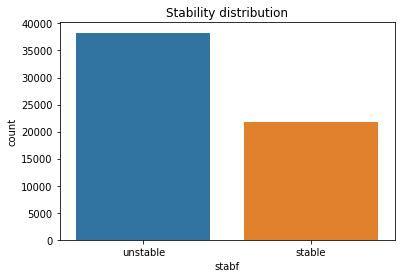

In [ ]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Text(0.5, 1.0, 'Stability distribution')

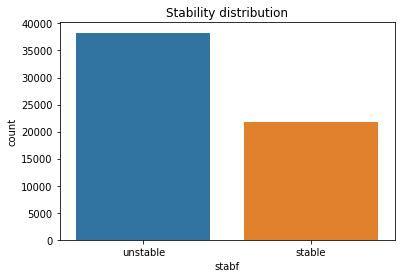

In [ ]:
ax = sns.countplot(x='stabf', data=dataset)
plt.title('Stability distribution')

Nakon prevođenja kategoričkog atributa "stabf", vrednost unstable je označena sa 1 , stable sa 0.

In [ ]:
shape = dataset.shape
print('Velicina dataseta')
print(shape)

Velicina dataseta
(60000, 14)


In [ ]:
dataset.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


tau1   -0.000005
tau2   -0.000001
tau3   -0.000001
tau4   -0.000001
p1     -0.012688
p2      0.000003
p3      0.000003
p4      0.000003
g1      0.000003
g2      0.000002
g3      0.000002
g4      0.000002
stab    0.018661
dtype: float64

In [ ]:
le = preprocessing.LabelEncoder()
dataset.stabf = le.fit_transform(dataset.stabf)

In [ ]:
dataset.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,1
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,0
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,1
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,1
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Text(0.5, 1.0, 'Correlation Heatmap')

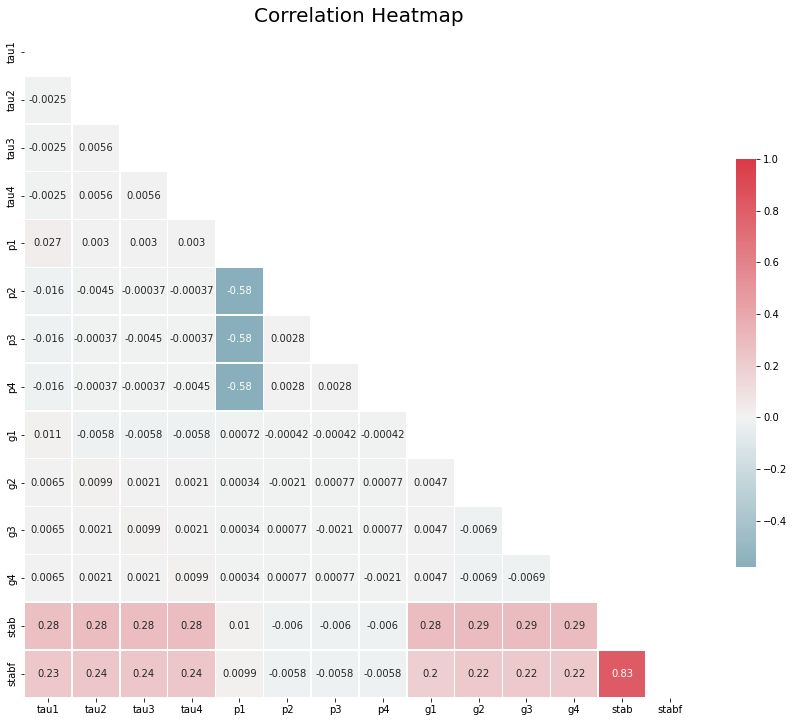

In [ ]:
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask,annot=True, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap', fontsize=20)

Kako postoji direktna veza između „stab“ i „stabf“ („stabf“ = „stable“ ako je „stab“ <= 0, u suprotnom „unstable“), „stabf“ će ostati kao jedina zavisna promenljiva

In [ ]:
X=dataset.iloc[:, :-2].values
y=dataset.iloc[:, 13].values

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_scaled=scaler.fit_transform(X)

<h1> Kreiranje modela </h1>

Kreiramo mrežu sa tri sloja.
Prvi skriveni sloj ima 10 čvorova i koristi Rectified Linear Unit (ReLU) aktivacionu funkciju.
Drugi skriveni sloj ima 6 čvorova i takođe koristi ReLu funkciju aktivacije.
Izlazni sloj ima jedan čvor i koristi sigmoidnu funkciju aktivacije. 
( input_dim = 12)
Koristi se binary crossentropy funkcija gubitka. proces učenja odvija se u 50 epoha i 1000 serija. 

In [ ]:
classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [ ]:
history=classifier.fit(X_train, y_train, validation_data = (X_test,y_test), batch_size=1000 , epochs=50 )

Epoch 1/50
42/42 [==============================] - 1s 10ms/step - loss: 0.6887 - accuracy: 0.6351 - val_loss: 0.6819 - val_accuracy: 0.6373
Epoch 2/50
42/42 [==============================] - 0s 4ms/step - loss: 0.6656 - accuracy: 0.6623 - val_loss: 0.6407 - val_accuracy: 0.7564
Epoch 3/50
42/42 [==============================] - 0s 5ms/step - loss: 0.5994 - accuracy: 0.7978 - val_loss: 0.5503 - val_accuracy: 0.8125
Epoch 4/50
42/42 [==============================] - 0s 5ms/step - loss: 0.5004 - accuracy: 0.8115 - val_loss: 0.4548 - val_accuracy: 0.8131
Epoch 5/50
42/42 [==============================] - 0s 5ms/step - loss: 0.4284 - accuracy: 0.8136 - val_loss: 0.4109 - val_accuracy: 0.8127
Epoch 6/50
42/42 [==============================] - 0s 5ms/step - loss: 0.4032 - accuracy: 0.8144 - val_loss: 0.3988 - val_accuracy: 0.8132
Epoch 7/50
42/42 [==============================] - 0s 5ms/step - loss: 0.3956 - accuracy: 0.8158 - val_loss: 0.3947 - val_accuracy: 0.8141
Epoch 8/50
42/42 [=

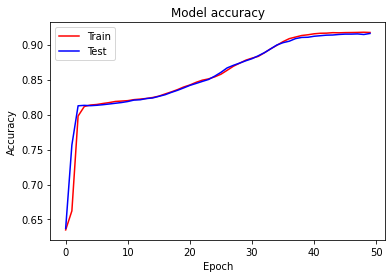

In [ ]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

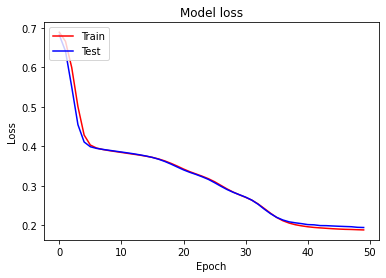

In [ ]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

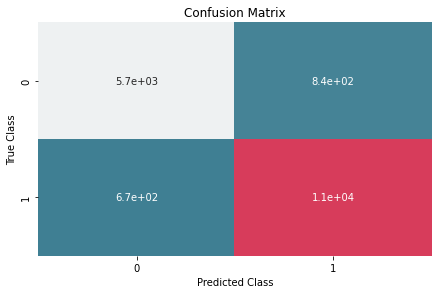

In [ ]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
class_names=[0,1]
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      6529
           1       0.93      0.94      0.93     11471

    accuracy                           0.92     18000
   macro avg       0.91      0.91      0.91     18000
weighted avg       0.92      0.92      0.92     18000



<h2> Smanjivanje overfitinga - Early Stopping </h2>

In [ ]:
classifier = Sequential()
classifier.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12))
classifier.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ["accuracy"] )

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

In [ ]:
history=classifier.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test), batch_size=1000 , epochs=60 )

Epoch 1/60
42/42 [==============================] - 1s 9ms/step - loss: 0.6889 - accuracy: 0.6350 - val_loss: 0.6820 - val_accuracy: 0.6373
Epoch 2/60
42/42 [==============================] - 0s 5ms/step - loss: 0.6636 - accuracy: 0.6383 - val_loss: 0.6351 - val_accuracy: 0.6373
Epoch 3/60
42/42 [==============================] - 0s 5ms/step - loss: 0.5921 - accuracy: 0.6383 - val_loss: 0.5478 - val_accuracy: 0.6373
Epoch 4/60
42/42 [==============================] - 0s 5ms/step - loss: 0.5175 - accuracy: 0.6383 - val_loss: 0.4956 - val_accuracy: 0.6373
Epoch 5/60
42/42 [==============================] - 0s 5ms/step - loss: 0.4823 - accuracy: 0.6655 - val_loss: 0.4725 - val_accuracy: 0.8081
Epoch 6/60
42/42 [==============================] - 0s 5ms/step - loss: 0.4616 - accuracy: 0.8131 - val_loss: 0.4528 - val_accuracy: 0.8138
Epoch 7/60
42/42 [==============================] - 0s 6ms/step - loss: 0.4392 - accuracy: 0.8153 - val_loss: 0.4276 - val_accuracy: 0.8122
Epoch 8/60
42/42 [==

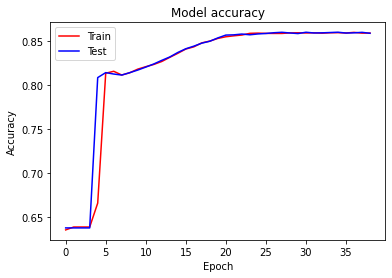

In [ ]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

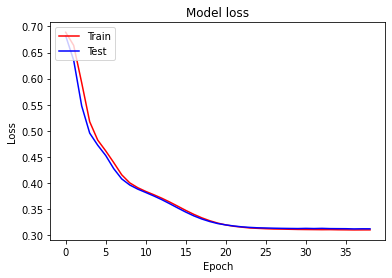

In [ ]:
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

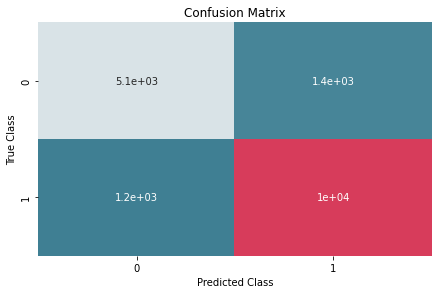

In [ ]:
y_pred = classifier.predict(X_test)
y_pred=(y_pred > 0.5)
class_names=[0,1]
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 5, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [ ]:
accuracy_Cross = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
print(classification_report(y_test, y_pred, target_names=target_names))


Classification report:

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      6529
           1       0.88      0.90      0.89     11471

    accuracy                           0.86     18000
   macro avg       0.85      0.84      0.85     18000
weighted avg       0.86      0.86      0.86     18000



<h2> Vizuelizacija neuronske mreže</h2>

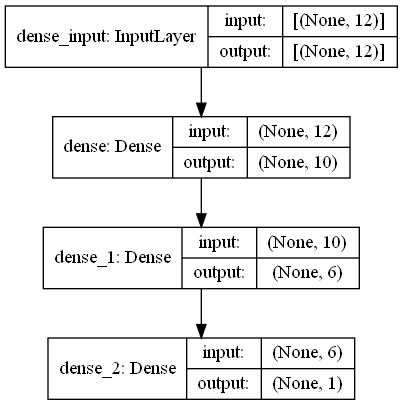

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
SVG(model_to_dot(classifier, show_shapes=True).create(prog="dot", format="svg"))
plot_model(classifier, show_shapes=True, to_file="network.png")

<h2> GridSearch - odabir najbojih hipermapametara mreže </h2>

In [ ]:
number_of_features=12
def create_network(optimizer="adam"):
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return network

In [ ]:

neural_network = KerasClassifier(build_fn=create_network, verbose=0)
epochs = [60,100]
batches = [50,100,1000]
optimizers = ["adam","rmsprop"]
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)
grid_result = grid.fit(X_scaled, y)

In [ ]:
grid_result.best_params_

{'batch_size': 100, 'epochs': 100, 'optimizer': 'adam'}

Nadalje će broj epoha i serija biti 100, i koristiće se adam optimizator. Koristiće se različite funkcije gubitka (loss fje).

<h2> Binary crossentropy </h2>

In [ ]:
def create_network_crossentropy():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return network

In [ ]:
neural_network = KerasClassifier(build_fn=create_network_crossentropy, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score with crossentropy loss",cross_val_score(neural_network, X_scaled, y, cv=20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Cross-validation score with crossentropy loss [0.95333332 0.95700002 0.94633335 0.94966668 0.95166665 0.95599997
 0.95999998 0.95666665 0.95499998 0.94266665 0.95099998 0.96033335
 0.95233333 0.954      0.96166664 0.96033335 0.95733333 0.95633334
 0.95200002 0.94199997]


In [ ]:
history=neural_network.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

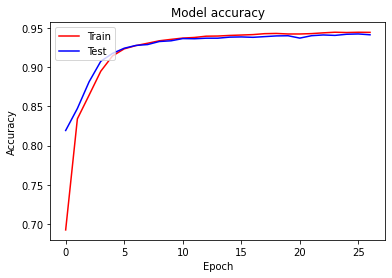

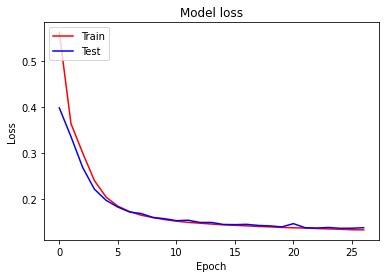

In [ ]:
plt.plot(history.history['accuracy'], "r-")
plt.plot(history.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'],"r-") 
plt.plot(history.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      6529
           1       0.94      0.97      0.95     11471

    accuracy                           0.94     18000
   macro avg       0.94      0.93      0.94     18000
weighted avg       0.94      0.94      0.94     18000



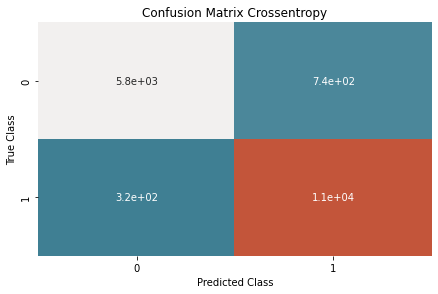

In [ ]:
y_pred = neural_network.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_crossentropy = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
target_names = ['0', '1']
class_names=[0,1]
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Crossentropy"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Hinge loss </h2>

In [ ]:
def create_network_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [ ]:
neural_network_hinge = KerasClassifier(build_fn=create_network_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score hinge loss function" ,cross_val_score(neural_network_hinge, X_scaled, y, cv=20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Cross-validation score hinge loss function [0.85366666 0.95200002 0.94933331 0.94266665 0.92333335 0.95233333
 0.85633332 0.84100002 0.92566669 0.935      0.86166668 0.88333333
 0.94599998 0.88300002 0.93266666 0.93266666 0.94533336 0.88800001
 0.93699998 0.93966669]


In [ ]:
history_hinge=neural_network_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))

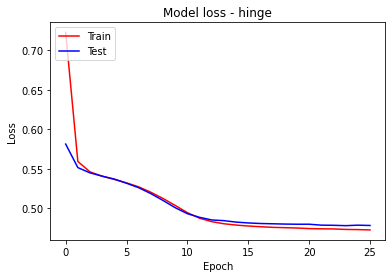

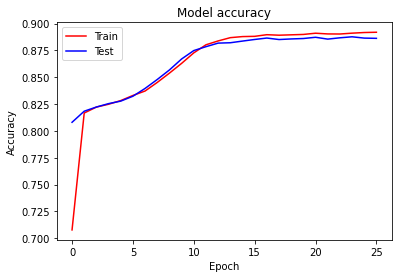

In [ ]:
plt.plot(history_hinge.history['loss'],"r-") 
plt.plot(history_hinge.history['val_loss'],"b-") 
plt.title('Model loss - hinge') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
plt.plot(history_hinge.history['accuracy'], "r-")
plt.plot(history_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      6529
           1       0.88      0.94      0.91     11471

    accuracy                           0.89     18000
   macro avg       0.89      0.86      0.87     18000
weighted avg       0.89      0.89      0.88     18000



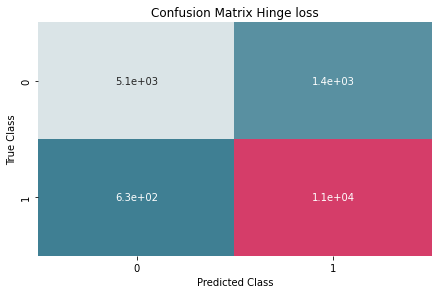

In [ ]:
y_pred = neural_network_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 0, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix Hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Squared hinge </h2>

In [ ]:
def create_network_squared_hinge():
    network = Sequential()
    network.add(layers.Dense(units=10, activation="relu",input_shape=(number_of_features,)))
    network.add(layers.Dense(units=6, activation="relu"))
    network.add(layers.Dense(units=1, activation="sigmoid"))
    network.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
    return network

In [ ]:
neural_network_squared_hinge = KerasClassifier(build_fn=create_network_squared_hinge, epochs=100, batch_size=100, verbose=0)
print("Cross-validation score squared hinge loss function" ,cross_val_score(neural_network_squared_hinge, X_scaled, y, cv=20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


Cross-validation score squared hinge loss function [0.94766665 0.94066668 0.94166666 0.93633336 0.92966664 0.93000001
 0.92966664 0.93633336 0.94066668 0.93300003 0.94599998 0.94366664
 0.95499998 0.93300003 0.95300001 0.94766665 0.92433333 0.91033334
 0.92866665 0.94833332]


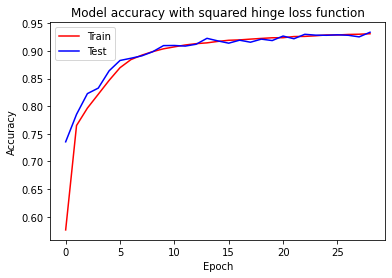

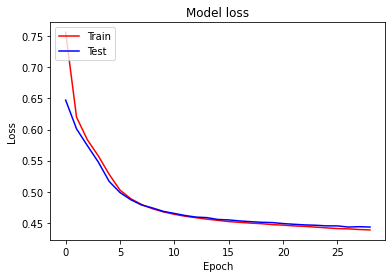

In [ ]:
history_squared_hinge=neural_network_squared_hinge.fit(X_train, y_train,callbacks=callbacks, validation_data = (X_test,y_test))
plt.plot(history_squared_hinge.history['accuracy'], "r-")
plt.plot(history_squared_hinge.history['val_accuracy'],  "b-")
plt.title('Model accuracy with squared hinge loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_squared_hinge.history['loss'],"r-") 
plt.plot(history_squared_hinge.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()


Classification report:

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      6529
           1       0.98      0.91      0.95     11471

    accuracy                           0.93     18000
   macro avg       0.92      0.94      0.93     18000
weighted avg       0.94      0.93      0.93     18000



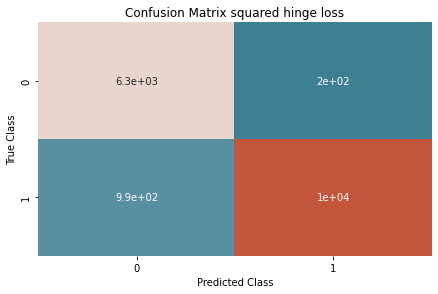

In [ ]:
y_pred = neural_network_squared_hinge.predict(X_test)
y_pred=(y_pred > 0.5)
accuracy_squared_hinge = accuracy_score(y_test, y_pred)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, target_names=target_names))
matrix = confusion_matrix(y_test, y_pred)
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(dataframe, annot=True, cbar=None, cmap=cmap)
plt.title("Confusion Matrix squared hinge loss"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

<h2> Dobijene tačnosti sa različitim loss funkcijama </h2>

Text(0.5, 0, 'Loss function')

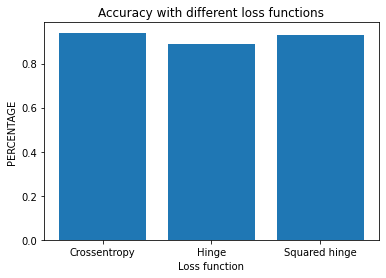

In [ ]:
name =[ 'Crossentropy','Hinge', 'Squared hinge']
accuracy = (round(accuracy_crossentropy, 2),round(accuracy_hinge, 2),round(accuracy_squared_hinge, 2))
bars=plt.bar(name, accuracy)
plt.title("Accuracy with different loss functions")
plt.ylabel('PERCENTAGE')
plt.xlabel('Loss function')

<h1> Regularizacija </h1>

Regularizacija je postupak za smanjenja overfittinga.

<h2> Dropout regularizacija </h2>


In [ ]:
network_dropout = Sequential()
network_dropout.add(layers.Dropout(0.2, input_shape=(number_of_features,)))
network_dropout.add(layers.Dense(units=10, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=6, activation="relu"))
network_dropout.add(layers.Dropout(0.5))
network_dropout.add(layers.Dense(units=1, activation="sigmoid"))
network_dropout.compile(loss="squared_hinge", optimizer="adam", metrics=["accuracy"])
history_dropout=network_dropout.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 3s 3ms/step - loss: 0.9806 - accuracy: 0.4200 - val_loss: 0.7438 - val_accuracy: 0.5705
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.8282 - accuracy: 0.4938 - val_loss: 0.6751 - val_accuracy: 0.7022
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7844 - accuracy: 0.5318 - val_loss: 0.6576 - val_accuracy: 0.7426
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7697 - accuracy: 0.5567 - val_loss: 0.6419 - val_accuracy: 0.7612
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.6375 - val_loss: 0.6376 - val_accuracy: 0.7658
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7340 - accuracy: 0.6966 - val_loss: 0.6319 - val_accuracy: 0.7772
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 0.7369 - accuracy: 0.6994 - val_loss: 0.6317 - val_accuracy: 0.7779

Epoch 58/100
420/420 [==============================] - 1s 3ms/step - loss: 0.7206 - accuracy: 0.7290 - val_loss: 0.6045 - val_accuracy: 0.8042
Epoch 59/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7251 - accuracy: 0.7243 - val_loss: 0.6087 - val_accuracy: 0.8009
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7235 - accuracy: 0.7233 - val_loss: 0.6042 - val_accuracy: 0.8071
Epoch 61/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7241 - accuracy: 0.7313 - val_loss: 0.6050 - val_accuracy: 0.7998
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7234 - accuracy: 0.7253 - val_loss: 0.6064 - val_accuracy: 0.7983
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7243 - accuracy: 0.7242 - val_loss: 0.6036 - val_accuracy: 0.8021
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.7271 - accuracy: 0.7211 - val_loss: 0.6042 - val_accuracy:

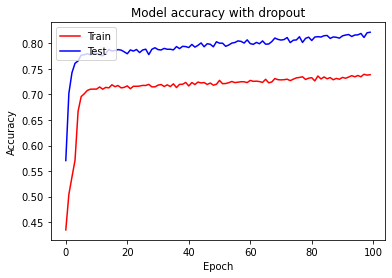

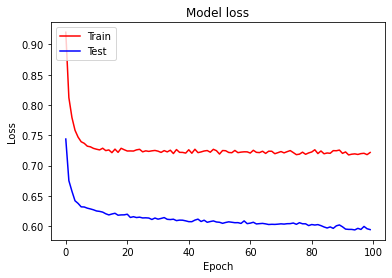

In [ ]:
plt.plot(history_dropout.history['accuracy'], "r-")
plt.plot(history_dropout.history['val_accuracy'],  "b-")
plt.title('Model accuracy with dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_dropout.history['loss'],"r-") 
plt.plot(history_dropout.history['val_loss'],"b-") 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [ ]:
y_pred = network_dropout.predict(X_test)
y_pred=(y_pred > 0.5)
dropout_loss, dropout_acc = network_dropout.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", dropout_loss)
print("Accuracy: ", dropout_acc)

563/563 - 1s - loss: 0.5943 - accuracy: 0.8221
Loss:  0.5942971110343933
Accuracy:  0.8220555782318115


<h2> L1 regularizacija </h2>

In [ ]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l1(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l1=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 3s 3ms/step - loss: 0.6829 - accuracy: 0.6350 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6574 - accuracy: 0.6335 - val_loss: 0.6556 - val_accuracy: 0.6367
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.6402 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6562 - accuracy: 0.6356 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 5/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6543 - accuracy: 0.6389 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6549 - accuracy: 0.6378 - val_loss: 0.6557 - val_accuracy: 0.6367
Epoch 7/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6407 - val_loss: 0.6555 - val_accuracy: 0.6367

Epoch 58/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6568 - accuracy: 0.6349 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 59/100
420/420 [==============================] - 1s 3ms/step - loss: 0.6533 - accuracy: 0.6406 - val_loss: 0.6557 - val_accuracy: 0.6367
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6543 - accuracy: 0.6389 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 61/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6533 - accuracy: 0.6409 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6543 - accuracy: 0.6388 - val_loss: 0.6556 - val_accuracy: 0.6367
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6545 - accuracy: 0.6386 - val_loss: 0.6555 - val_accuracy: 0.6367
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.6524 - accuracy: 0.6423 - val_loss: 0.6555 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l1_loss, l1_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l1_loss)
print("Accuracy: ", l1_acc)

563/563 - 1s - loss: 0.6555 - accuracy: 0.6367
Loss:  0.6555068492889404
Accuracy:  0.636722207069397


<h2> L2 regularizacija </h2>

In [ ]:
model = Sequential()
model.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' ,kernel_regularizer=regularizers.l2(0.01), input_dim = 12))
model.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid',))
model.compile(optimizer = 'adam', loss ='binary_crossentropy' , metrics = ["accuracy"])
history_l2=model.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 2s 3ms/step - loss: 0.6456 - accuracy: 0.6340 - val_loss: 0.5149 - val_accuracy: 0.8007
Epoch 2/100
420/420 [==============================] - 1s 2ms/step - loss: 0.5069 - accuracy: 0.8005 - val_loss: 0.4828 - val_accuracy: 0.8072
Epoch 3/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.8138 - val_loss: 0.4627 - val_accuracy: 0.8118
Epoch 4/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4571 - accuracy: 0.8169 - val_loss: 0.4492 - val_accuracy: 0.8118
Epoch 5/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4481 - accuracy: 0.8136 - val_loss: 0.4409 - val_accuracy: 0.8128
Epoch 6/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4394 - accuracy: 0.8142 - val_loss: 0.4341 - val_accuracy: 0.8121
Epoch 7/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.8166 - val_loss: 0.4296 - val_accuracy: 0.8134

Epoch 58/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4005 - accuracy: 0.8175 - val_loss: 0.4051 - val_accuracy: 0.8117
Epoch 59/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4001 - accuracy: 0.8145 - val_loss: 0.4032 - val_accuracy: 0.8126
Epoch 60/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4011 - accuracy: 0.8143 - val_loss: 0.4030 - val_accuracy: 0.8136
Epoch 61/100
420/420 [==============================] - 1s 3ms/step - loss: 0.4012 - accuracy: 0.8144 - val_loss: 0.4042 - val_accuracy: 0.8121
Epoch 62/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4014 - accuracy: 0.8153 - val_loss: 0.4033 - val_accuracy: 0.8122
Epoch 63/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4017 - accuracy: 0.8157 - val_loss: 0.4030 - val_accuracy: 0.8125
Epoch 64/100
420/420 [==============================] - 1s 2ms/step - loss: 0.4034 - accuracy: 0.8123 - val_loss: 0.4022 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test)
y_pred=(y_pred > 0.5)
l2_loss, l2_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Loss: ", l2_loss)
print("Accuracy: ", l2_acc)

563/563 - 1s - loss: 0.4012 - accuracy: 0.8131
Loss:  0.4012114703655243
Accuracy:  0.8131111264228821


<h2> Custom loss funkcija </h2>


In [ ]:
def custom_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    loss= -(y_true*K.log(y_pred) - (1-y_true)*K.log(1-y_pred)**2)
    loss = K.sum(loss, axis=1)       
    
    return loss

In [ ]:
classifier_cl = Sequential()
classifier_cl.add(Dense( 10,  kernel_initializer = 'uniform', activation = 'relu' , input_dim = 12,dtype='float32'))
classifier_cl.add(Dense( 6,  kernel_initializer = 'uniform', activation = 'relu'))
classifier_cl.add(Dense( 1,  kernel_initializer = 'uniform', activation = 'sigmoid'))

In [ ]:
classifier_cl.compile(optimizer = 'adam', loss =custom_loss , metrics = ["accuracy"], run_eagerly=True )

In [ ]:
history_cl=classifier_cl.fit(X_train, y_train,validation_data = (X_test,y_test), batch_size=100 , epochs=100 )

Epoch 1/100
420/420 [==============================] - 10s 24ms/step - loss: 0.5370 - accuracy: 0.7169 - val_loss: 0.3823 - val_accuracy: 0.8073
Epoch 2/100
420/420 [==============================] - 10s 24ms/step - loss: 0.3707 - accuracy: 0.8145 - val_loss: 0.3365 - val_accuracy: 0.8414
Epoch 3/100
420/420 [==============================] - 10s 24ms/step - loss: 0.3254 - accuracy: 0.8452 - val_loss: 0.2771 - val_accuracy: 0.8794
Epoch 4/100
420/420 [==============================] - 10s 24ms/step - loss: 0.2575 - accuracy: 0.8832 - val_loss: 0.2269 - val_accuracy: 0.9043
Epoch 5/100
420/420 [==============================] - 10s 25ms/step - loss: 0.2236 - accuracy: 0.9068 - val_loss: 0.2118 - val_accuracy: 0.9111
Epoch 6/100
420/420 [==============================] - 10s 23ms/step - loss: 0.2066 - accuracy: 0.9147 - val_loss: 0.2090 - val_accuracy: 0.9123
Epoch 7/100
420/420 [==============================] - 10s 24ms/step - loss: 0.2060 - accuracy: 0.9155 - val_loss: 0.2073 - val_ac

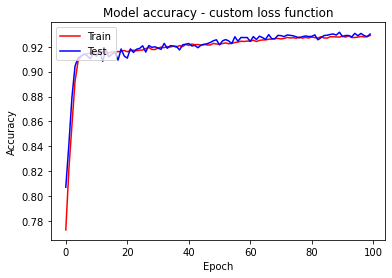

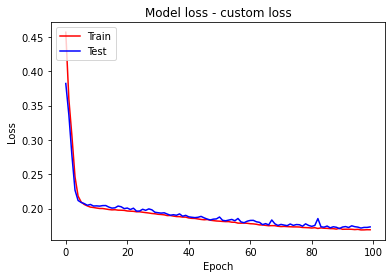

In [ ]:
plt.plot(history_cl.history['accuracy'], "r-")
plt.plot(history_cl.history['val_accuracy'],  "b-")
plt.title('Model accuracy - custom loss function')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history_cl.history['loss'],"r-") 
plt.plot(history_cl.history['val_loss'],"b-") 
plt.title('Model loss - custom loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

<h1> Zaključak </h1>

Kreirana neuronska mreža je u nekim slučajevima dala jako dobre rezultate. Rezultati su bili lošiji onda kada su korišćene tehnike smanjivanja overfittinga.
Neuronska mreža je jako dobro obučena i dala je dobre rezultate onda kada je kreirana custom loss funkcija, koja je prilagođena problemu.